<h1 align="center">Building a better embedding</h1>

## Data for embeddings

When representing materials in ML models there is a hierachy of structure; Target property > Material Embedding > Atomic Embeddings. Current Atomics embeddings have the scope to include more physics, the principle area's where existing attempts fall short are not including infomation about the form factor or the expected spins of the most abundant isotopes.

To try construct a better embedding we have prepared a dataset of atomic features by collecting infomation from multiple sources; Mathematica, Wikipedia, Textbooks and other websites. We discard elements heavier than Californium because the International Tables for Crystallography do not give form factors for heavier elements. 

Signifcant overlap exists between the infomation contained in our dataset and previous attempts for featurising materials such as [Magpie](http://oqmd.org/static/analytics/magpie/doc/). Magpie takes a list of feature properties to use and carries out an end-to-end model throwing errors it if encounters missing values. This puts emphasis on selecting a feature set that is fully detemined for the problem. 

In contrast, we want to construct an embedding which means that we need a dense representation where every column is given for each atomic key. This moves the issue of dealing with missing data from run-time to the problem setup phase.

In [1]:
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("atom_data.csv", header=None)
df = df.set_index(df.columns[0])

percent_missing = 100*(df.size - df.count().sum())/df.size
print("The percentage of missing data is {:.2f}".format(percent_missing))

df_dense =  df.dropna(axis=1, how='any')
percent_dense = 100*df_dense.size/df.size
print("The percentage of dense data is {:.2f}".format(percent_dense))

print("The percentage of unnecessarily discarded data is {:.2f}".format(100-percent_dense-percent_missing))


The percentage of missing data is 7.79
The percentage of dense data is 56.62
The percentage of unnecessarily discarded data is 35.59


In order to use the collected atom data as an embedding for machine learning we need a dense representation. We can relatively straightforwardly produce a dense representation by dropping any columns with missing values but we see that doing this results in discarding 35.59% of our data.

A better way to obtain a dense representation would be on a problem by problem basis where we first check which elements are present in the data and drop the rows corresponding to elements that are not present first before dropping the columns where we still have missing values. This is essentially what we would be doing implicitly if using Magpie. Evidently reducing the allowed elemet set reduces the ability of the embedding to generalise. Using this improved scheme we may get away with discarding less data but having to discard any data is non-ideal. 

The alternative to dropping data is to impute values. When imputing it is important to consider why the data is missing, in general there are three types of missing data:

* Missing completely at random (MCAR)
* Missing at random (MAR)
* Missing not at random (MNAR)

In practise we onyl consider data MAR and MNAR as for data to be MCAR means requires that it is unrelated to the problem being investigated. In our problem MAR data is data that could have been collected about an atom but hasn't been and MNAR data is data that is missing because it doesn't exist i.e. the P-Zunger radius for Helium.

In the first instance we will do a simple linear interpolation. 

In [3]:
df_imputed = df.interpolate('linear', limit_direction='both')

# note it is critical here that we normalise our data before the correlation
normalized_df=(df_imputed-df_imputed.mean())/df_imputed.std()

embedding = normalized_df.T.to_dict('list')

with open('elem_embedding.json', 'w') as f:
    json.dump(embedding, f)

In order to visualise the embedding a good figure is to look at the correlation plot, this shows us the similarity between different atoms in the embedding scheme.

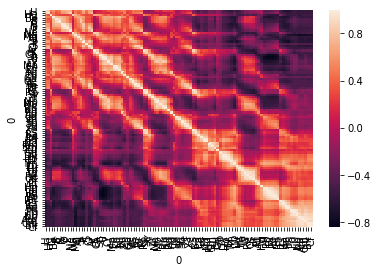

In [4]:
corr = normalized_df.T.corr()

plt.figure()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Dimensionality reduction

Often, particularly when dealing smaller datasets (i.e. real experimental data), we want to ensure that we reduce the dimensionality of out problem as much as possible as this reduces the extent to which our system will be over-parameterised (under-determined).

A straightforward and well established dimensionality reduction approach is Principle Componet Analysis (PCA). PCA converts a set of possibly correlated variables into a set of values of linearly uncorrelated variables that are refered to as the principal components of the system. Think of it by analogy to taking the leading terms when projecting onto a orthogonal basis set of vectors.

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=16)

low = pca.fit_transform(normalized_df.values)

df_low = pd.DataFrame(low,index=df.index)

embedding = df_low.T.to_dict('list')

with open('elem_low_embedding.json', 'w') as f:
    json.dump(embedding, f)

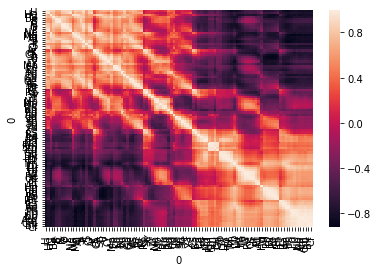

In [6]:
corr = df_low.T.corr()

plt.figure()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)